In [36]:
from pre_processing import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
import joblib

pd.set_option("display.max_columns", None)

## Data processing
Load data in a single dataframe and split into train and test

In [45]:
PATH = './Train/Train'

df = load_general(PATH)

df_train, df_test = train_test_split(df)

df.describe()


,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
count,55875.000000,55875.000000,55875.000000,55875.000000,5.587500e+04,55875.0,55875.0,55875.000000,55875.000000,55875.000000,55875.000000,55800.000000,55800.000000,55500.000000,55800.000000,55800.000000,55800.000000,55800.0,55575.000000,43050.000000,43275.000000,43050.000000,43275.000000,55800.000000
mean,238.000000,39.471010,-0.372940,19.560000,1.413454e+09,2014.0,10.0,16.013423,11.487248,84.583893,0.064430,11.406855,4.694489,170.227162,21.707796,65.943548,1002.257258,0.0,7.437607,0.002956,7.412268,0.002956,7.412268,7.442186
std,21.648904,0.013061,0.023094,5.702074,7.742329e+05,0.0,0.0,8.945842,6.926340,46.566917,0.245519,8.664456,4.583093,86.912565,3.271253,16.724256,42.523692,0.0,6.542969,4.686462,5.957532,4.686462,5.957532,6.541292
min,201.000000,39.444093,-0.409316,14.000000,1.412114e+09,2014.0,10.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.900000,18.000000,811.900000,0.0,0.000000,-39.000000,0.000000,-39.000000,0.000000,0.000000
25%,219.000000,39.462808,-0.393181,15.000000,1.412784e+09,2014.0,10.0,8.000000,5.000000,47.000000,0.000000,4.800000,1.600000,135.000000,19.400000,54.000000,1009.675000,0.0,2.000000,-1.666667,2.750000,-1.666667,2.750000,2.000000
50%,238.000000,39.469844,-0.375973,20.000000,1.413454e+09,2014.0,10.0,16.000000,11.000000,85.000000,0.000000,9.700000,3.200000,180.000000,21.350000,68.000000,1015.350000,0.0,6.000000,0.000000,6.000000,0.000000,6.000000,6.000000
75%,257.000000,39.480591,-0.354640,20.000000,1.414123e+09,2014.0,10.0,24.000000,17.000000,122.000000,0.000000,16.100000,6.400000,202.500000,23.400000,81.000000,1021.500000,0.0,12.000000,1.666667,11.000000,1.666667,11.000000,12.000000
max,275.000000,39.495034,-0.328902,40.000000,1.414793e+09,2014.0,10.0,31.000000,23.000000,168.000000,1.000000,43.500000,27.400000,337.500000,34.600000,91.000000,1084.900000,0.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000


Perform data processing and basic feature selection

In [46]:
#drop instance where there's no number of bikes
df_train = drop_nan_bikes(df_train)

# #replaces days with numbers
df_train = day_transform(df_train)
df_test = day_transform(df_test)

# #replaces NaN with median
df_train = nan_impute(df_train)
df_test = nan_impute(df_test)

# #removes features with zero variance
df_train = var_transform(df_train)
df_test = var_transform(df_test)

# #has_nan(df_test)
#
df_test

,station,latitude,longitude,numDocks,timestamp,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,244.0,39.473317,-0.328902,15.0,1.413335e+09,15.0,3.0,3.0,52.0,0.0,14.5,8.0,180.0,18.4,57.0,1010.0,11.0,-2.000000,8.000000,-2.000000,8.000000,13.0
1,263.0,39.494718,-0.386875,15.0,1.414112e+09,24.0,3.0,5.0,100.0,0.0,6.4,1.6,180.0,19.4,47.0,1017.6,12.0,0.000000,9.000000,0.000000,9.000000,12.0
2,263.0,39.494718,-0.386875,15.0,1.413097e+09,12.0,9.0,7.0,154.0,1.0,25.7,11.3,225.0,20.6,59.0,1008.3,8.0,-2.000000,1.000000,-2.000000,1.000000,8.0
3,264.0,39.495034,-0.382369,15.0,1.412914e+09,10.0,6.0,5.0,103.0,0.0,0.0,0.0,180.0,19.7,75.0,1010.7,8.0,0.000000,11.000000,0.000000,11.000000,9.0
4,248.0,39.455440,-0.366517,23.0,1.414627e+09,30.0,1.0,4.0,74.0,0.0,1.6,0.0,157.5,17.7,88.0,1020.7,8.0,0.250000,19.750000,0.250000,19.750000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13964,235.0,39.489661,-0.358709,15.0,1.413004e+09,11.0,7.0,6.0,128.0,0.0,14.5,8.0,202.5,20.2,70.0,1012.2,11.0,6.000000,14.000000,6.000000,14.000000,13.0
13965,227.0,39.444093,-0.367664,15.0,1.413796e+09,20.0,11.0,1.0,12.0,0.0,9.7,1.6,202.5,21.2,59.0,1024.7,15.0,-1.500000,11.500000,-1.500000,11.500000,12.0
13966,250.0,39.446050,-0.380387,18.0,1.414332e+09,26.0,15.0,7.0,160.0,0.0,16.1,8.0,22.5,23.1,64.0,1021.5,16.0,0.333333,16.333333,0.333333,16.333333,16.0
13967,216.0,39.464090,-0.370052,17.0,1.412950e+09,10.0,16.0,5.0,113.0,0.0,24.1,9.7,202.5,27.8,41.0,1010.0,12.0,0.000000,11.000000,0.000000,11.000000,6.0


Find which feature has highest correlation with bikes

Find inter-feature correlation and drop features with a correlation higher than 0.95

Obviously windmean and windmax are positively correlated.

['day', 'weekhour', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


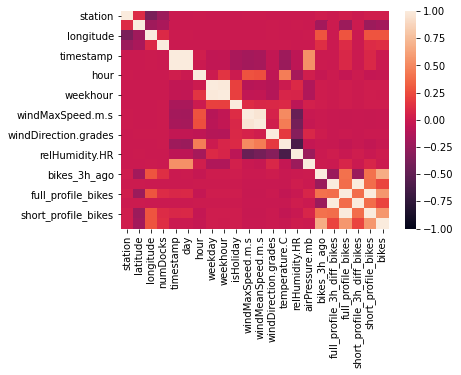

In [39]:
sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0)

dropped = high_correl(df_train, 0.95)
dropped = high_correl(df_test, 0.95)
print(dropped)

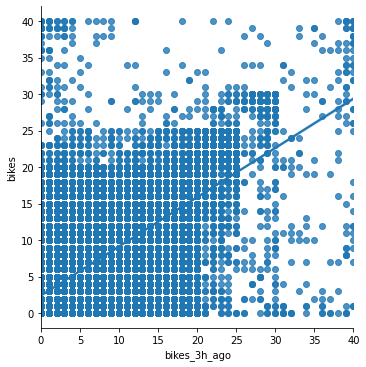

In [40]:
sns.lmplot(data= df_train, x='bikes_3h_ago', y='bikes')

In [41]:
corr_matrix = correl(df_train)
print(corr_matrix['bikes'].sort_values(ascending=False).head(10))

bikes                         1.000000
bikes_3h_ago                  0.673059
full_profile_bikes            0.573669
longitude                     0.282682
full_profile_3h_diff_bikes    0.224778
latitude                      0.193182
numDocks                      0.117553
hour                          0.027228
station                       0.024675
temperature.C                 0.022714
Name: bikes, dtype: float64


## Model selection

In [42]:
#store features and target in two different dataframes
X_train = df_train.loc[:, df_train.columns != 'bikes']
Y_train = df_train['bikes']
X_test = df_test.loc[:, df_test.columns != 'bikes']
Y_test= df_test['bikes']

In [43]:
Y_test.dtypes

dtype('float64')

Experiment with baseline methods

In [44]:
pipelines = [('Linear regression', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])),
             ('Ridge', Pipeline([('Scaler', StandardScaler()),('L2',Ridge())])),
             ('DecisionTree',Pipeline([('Scaler', StandardScaler()),('DT',DecisionTreeRegressor())])),
             ('RandomForest',Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])),
             ('KNN',Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])),
             ('SVR',Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])),
             ('GradientBoosting', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())]))]
#shuffle the data to preserve generality (avoids overfitting)
#df[i] = shuffle(df[i])

for model, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'Model {model} : {cv_scores.mean()}\n')

print("\n")

Model Linear regression : -2.860351941508669

Model Ridge : -2.8603777505882597

Model DecisionTree : -3.090952141322595

Model RandomForest : -2.2948174740283624

Model KNN : -2.5109115466091865

Model SVR : -2.4966359916902343

Model GradientBoosting : -2.6262318039968937





As it is possible to see RandomForest and SVR are the ones that perform better. Let's try to tune Random Forest first

In [8]:
param_grid_forest = {'n_estimators': np.arange(100, 2000, 500),
          'max_features': ['auto', 'sqrt'],
          'max_depth': [np.arange(5, 100, 19), None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]
         }

tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(),
                              param_distributions = param_grid_forest, n_iter = 20,
                              verbose = 2, n_jobs = -5, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
tree_reg.fit(X_train, Y_train)
joblib.dump(tree_reg.best_estimator_, "randomforest.joblib")
print(f'Best parameters for dataset are {tree_reg.best_params_}')
print(f'Best score is {tree_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for dataset are {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best score is -2.210095615426397


[Parallel(n_jobs=-5)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-5)]: Done  25 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-5)]: Done 100 out of 100 | elapsed: 24.8min finished


ValueError: Number of features of the model must match the input. Model n_features is 16 and input n_features is 21 

In [18]:
predictions = tree_reg.best_estimator_.predict(X_test)
test_error = mean_absolute_error(predictions, Y_test)
print(f"The MAE on the test set is {test_error}\n")


The MAE on the test set is 2.114306917698714



We got an accuracy of nearly 79% on the test set.

Now tune Support Vector Machine Regressor

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values.astype(np.float))
Y_train = scaler.fit_transform(Y_train.values.astype(np.float).reshape(-1, 1))

param_grid_kernel = {#'kernel': ['poly', 'rbf', 'sigmoid'],
                     #'epsilon': np.arange(0.1, 1.0, 0.1),
                     'gamma': [0.01, 0.1, 0.5, 1],
                     'C': [0.1, 1, 10, 100]
                       }
#pipe = make_pipeline(StandardScaler(), SVR())
svr_reg = RandomizedSearchCV(estimator=SVR(),
                        param_distributions = param_grid_kernel, n_iter = 10,
                        verbose = 3, n_jobs = -3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
svr_reg.fit(X_train, Y_train)
joblib.dump(svr_reg.best_estimator_, "svr.joblib")
print(f'Best parameters for dataset are {svr_reg.best_params_}')
print(f'Best score is {svr_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-3)]: Done  48 out of  50 | elapsed: 60.0min remaining:  2.5min


KeyboardInterrupt: 

In [29]:
X_train

array([[241.        ,  39.46984411,  -0.32964496, ...,   3.        ,
          1.5       ,  11.5       ],
       [233.        ,  39.47854813,  -0.342366  , ...,   4.        ,
          0.        ,   6.25      ],
       [237.        ,  39.48567015,  -0.37859211, ...,   0.        ,
         11.        ,  12.        ],
       ...,
       [208.        ,  39.46905609,  -0.3757281 , ...,  29.        ,
         -8.25      ,  18.75      ],
       [268.        ,  39.45947405,  -0.40283117, ...,  11.        ,
          0.        ,   1.        ],
       [205.        ,  39.47078409,  -0.38270112, ...,   5.        ,
          1.5       ,   1.5       ]])